# OCEAN Token Sentiment Analysis Challenge

### Data preparation for model training + Tabular model training + Inference
By Luca Ordronneau

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import requests
from io import StringIO

import warnings
warnings.filterwarnings("ignore")

import re
import json
import string
import itertools

import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
wn.ensure_loaded()

pd.set_option('display.max_columns', None)

In [2]:
df_tweet = pd.read_csv('../data/$OCEAN tweets dataset.csv')
df_price = pd.read_csv('../data/OCEAN token price dataset.csv')

In [3]:
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_tweet['date'] = pd.to_datetime(df_tweet['date']+' '+df_tweet['time'])

df_price.sort_values(by="Date", inplace=True)
df_tweet.sort_values(by="date", inplace=True)

In [4]:
df_tweet.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [5]:
df_tweet['translate'].unique()

array([nan])

In [6]:
df_tweet

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
229856,1211807901087666176,1211722656665325574,2019-12-31 02:34:52 GTB,2019-12-31 02:34:52,02:34:52,300,1170188995453734912,tychowaterhouse,Tycho Waterhouse,NaN,@oyepana2 @bakeobits Welcome to $OCEAN. Where...,en,[],[],[],1,0,2,[],['ocean'],https://twitter.com/TychoWaterhouse/status/121...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'bakeobits', 'name': 'ShillSi...",NaN,NaN,NaN,NaN
229855,1211808120659300352,1211808120659300352,2019-12-31 02:35:44 GTB,2019-12-31 02:35:44,02:35:44,300,999799024273141760,bakeobits,ShillSilverstein.kek 📈👑📉,NaN,$OCEAN here with 3RV Chart Pattern https://t....,en,[],[],['https://pbs.twimg.com/media/ENE1D4GUYAAWcVh....,2,0,0,[],['ocean'],https://twitter.com/bakeobits/status/121180812...,False,NaN,1,https://pbs.twimg.com/media/ENE1D4GUYAAWcVh.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
229854,1211818209738817536,1211818209738817536,2019-12-31 03:15:50 GTB,2019-12-31 03:15:50,03:15:50,300,999799024273141760,bakeobits,ShillSilverstein.kek 📈👑📉,NaN,There's a good chance that $INS is going to pu...,en,[],[],[],2,0,1,[],"['ins', 'ocean', 'ins']",https://twitter.com/bakeobits/status/121181820...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
229853,1211830366513901568,1211782150443479042,2019-12-31 04:04:08 GTB,2019-12-31 04:04:08,04:04:08,300,897905830334533632,harmoniccapital,Harmonic Capital,NaN,"@DaveCryptos $Sharering, $ocean, Blocktrade lol",en,[],[],[],0,0,0,[],['ocean'],https://twitter.com/harmoniccapital/status/121...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'DaveCryptos', 'name': 'Dave ...",NaN,NaN,NaN,NaN
229852,1211845595977019392,1211774284965859328,2019-12-31 05:04:39 GTB,2019-12-31 05:04:39,05:04:39,300,3307664430,mojo_crypto_btc,🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL,NaN,@Pentoshiswallet Solid picks... I’d replace $x...,en,[],[],[],0,0,3,[],"['xrp', 'perl', 'nrg', 'ocean']",https://twitter.com/Mojo_Crypto_BTC/status/121...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1583595987851173888,1583557616558833665,2022-10-22 02:07:59 GTB (heure d’été),2022-10-22 02:07:59,02:07:59,300,1258748447873806336,stringerbcoiner,StringerBitcoiner,NaN,"@cryptoworld202 $OCEAN, $LTC, $NGM and $DAFI a...",en,"[{'screen_name': 'emoney_com', 'name': 'e-mone...",[],['https://pbs.twimg.com/media/FfoQJTUWQAMjfYy....,1,0,2,"['ngm', 'dafi', 'ngm']","['ocean', 'ltc', 'ngm', 'dafi', 'esek', 'enok'...",https://twitter.com/StringerBcoiner/status/158...,False,NaN,1,https://pbs.twimg.com/media/FfoQJTUWQAMjfYy.jpg,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'cryptoworld202', 'name': 'Cr...",NaN,NaN,NaN,NaN
3,1583598008511664128,1583595613903417344,2022-10-22 02:16:01 GTB (heure d’été),2022-10-22 02:16:01,02:16:01,300,3275094379,rjgaurav338,rikdbxs,NaN,"@CryptoGemsCom I have been buying $OCEAN, $BNB...",en,[],[],[],0,0,0,[],"['ocean', 'bnb', 'eth']",https://twitter.com/rjgaurav338/status/1583598...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'CryptoGemsCom', 'name': 'The...",NaN,NaN,NaN,NaN
2,1583603064044367872,1583603064044367872,2022-10-22 02:36:07 GTB (heure d’été),2022-10-22 02:36:07,02:36:07,300,1319369787848405003,moonhodler2,MOONHODLER,NaN,"""The Energy Efficiency Data challenge is desig...",en,"[{'screen_name': 'oceanprotocol', 'name': 'oce...",[],[],0,0,0,['data'],['ocean'],https://twitter.com/Moonhodler2/status/1583603...,False,https://twitter.com/oceanprotocol/status/15834...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1583607565543669761,1583607565543669761,2022-10-22 02:54:00 GTB (heure d’été)

# Labeling
Use of the API to get Fear & Greed Index

In [7]:
# Making the API request
response = requests.get("https://api.alternative.me/fng/?limit=1000000")

# Checking if the request was successful
if response.status_code == 200:
    data = response.json()

    df_labels = pd.json_normalize(data['data']) 

else:
    print(f"Request failed with status code {response.status_code}")


Change the naming of the labels:
- Fear is more associated with a Bearish market
- Greed is more associated with a Bullish market

In [8]:
df_labels['value_classification'] = df_labels['value_classification'].str.replace('Extreme Fear','Bearish')
df_labels['value_classification'] = df_labels['value_classification'].str.replace('Extreme Greed','Bullish')
df_labels['value_classification'] = df_labels['value_classification'].str.replace('Fear','Bearish')
df_labels['value_classification'] = df_labels['value_classification'].str.replace('Greed','Bullish')

In [9]:
df_labels['timestamp'] = pd.to_datetime(df_labels['timestamp'], unit='s')

In [10]:
df_labels.sort_values(by="timestamp", inplace=True)

In [11]:
dict_labels = {"Bearish":0, "Neutral":1, "Bullish":2}

df_labels['target'] = df_labels['value_classification'].map(dict_labels)

In [12]:
df_price = pd.merge(df_price, df_labels[["timestamp", "target"]], left_on="Date", right_on="timestamp")

# Features creation
### Tabular data 
Encode time in a cyclical way

In [13]:
from math import ceil

def week_of_month(dt):
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def get_time_indicators(df):
    df['hour'] = df['date'].dt.hour
    df['day_week'] = df['date'].dt.day_of_week
    df['day'] = df['date'].dt.day - 1
    df['week'] = df['date'].apply(week_of_month) - 1
    df['month'] = df['date'].dt.month
    return df

def encode_time_indicators(data, col, max_val):
    data[f'feature_{col}_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[f'feature_{col}_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

def populate_time_indicators(df):
    df = encode_time_indicators(df, 'hour', 23)
    df = encode_time_indicators(df, "day_week", 6)
    df = encode_time_indicators(df, 'day', 30)
    df = encode_time_indicators(df, 'week', 5)
    df = encode_time_indicators(df, 'month', 12)
    return df

In [14]:
df_tabular = pd.merge_asof(df_tweet, df_price, left_on="date", right_on="Date")

In [15]:
df_tabular = get_time_indicators(df_tabular)
df_tabular = populate_time_indicators(df_tabular)

In [16]:
df_tabular["feature_cum_sum_tweet_count"] = df_tabular.groupby([pd.Grouper(key='date', freq='D')], as_index=False).cumcount() + 1
df_tabular["feature_cum_sum_unique_user_count"] = df_tabular.groupby([pd.Grouper(key='date', freq='D'), "user_id"], as_index=False).cumcount() + 1

Data manipulation to create new features

In [17]:
df_tabular["feature_replies_count"]  = df_tabular["replies_count"]
df_tabular["feature_retweets_count"] = df_tabular["retweets_count"]
df_tabular["feature_likes_count"]    = df_tabular["likes_count"]
df_tabular["feature_hashtags"]       = df_tabular["hashtags"].apply(lambda x: len(x))
df_tabular["feature_cashtags"]       = df_tabular["cashtags"].apply(lambda x: len(x))
df_tabular["feature_mentions"]       = df_tabular["mentions"].apply(lambda x: len(x))
df_tabular["feature_quote_url"]      = df_tabular["quote_url"].notna().astype(int)
df_tabular["feature_video"]          = df_tabular["video"]
df_tabular["feature_thumbnail"]      = df_tabular["thumbnail"].notna().astype(int)
df_tabular["feature_open"]           = df_tabular["Open"]
df_tabular["feature_high"]           = df_tabular["High"]
df_tabular["feature_low"]            = df_tabular["Low"]
df_tabular["feature_close"]          = df_tabular["Close"]
df_tabular["feature_volume"]         = df_tabular["Volume"]

In [18]:
df_tabular = df_tabular[[col for col in df_tabular if col.startswith('feature_')] + ['target']]

In [19]:
df_tabular.head()

,feature_hour_sin,feature_hour_cos,feature_day_week_sin,feature_day_week_cos,feature_day_sin,feature_day_cos,feature_week_sin,feature_week_cos,feature_month_sin,feature_month_cos,feature_cum_sum_tweet_count,feature_cum_sum_unique_user_count,feature_replies_count,feature_retweets_count,feature_likes_count,feature_hashtags,feature_cashtags,feature_mentions,feature_quote_url,feature_video,feature_thumbnail,feature_open,feature_high,feature_low,feature_close,feature_volume,target
0,0.519584,0.854419,0.866025,0.5,-1.133108e-15,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,1,1,1,0,2,2,9,2,0,0,0,0.0327,0.038978,0.032562,0.037197,12297226,0
1,0.519584,0.854419,0.866025,0.5,-1.133108e-15,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,2,1,2,0,0,2,9,2,0,1,1,0.0327,0.038978,0.032562,0.037197,12297226,0
2,0.730836,0.682553,0.866025,0.5,-1.133108e-15,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,3,2,2,0,1,2,23,2,0,0,0,0.0327,0.038978,0.032562,0.037197,12297226,0
3,0.887885,0.460065,0.866025,0.5,-1.133108e-15,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,4,1,0,0,0,2,9,2,0,0,0,0.0327,0.038978,0.032562,0.037197,12297226,0
4,0.979084,0.203456,0.866025,0.5,-1.133108e-15,1.0,-2.449294e-16,1.0,-2.449294e-16,1.0,5,1,0,0,3,2,31,2,0,0,0,0.0327,0.038978,0.032562,0.037197,12297226,0


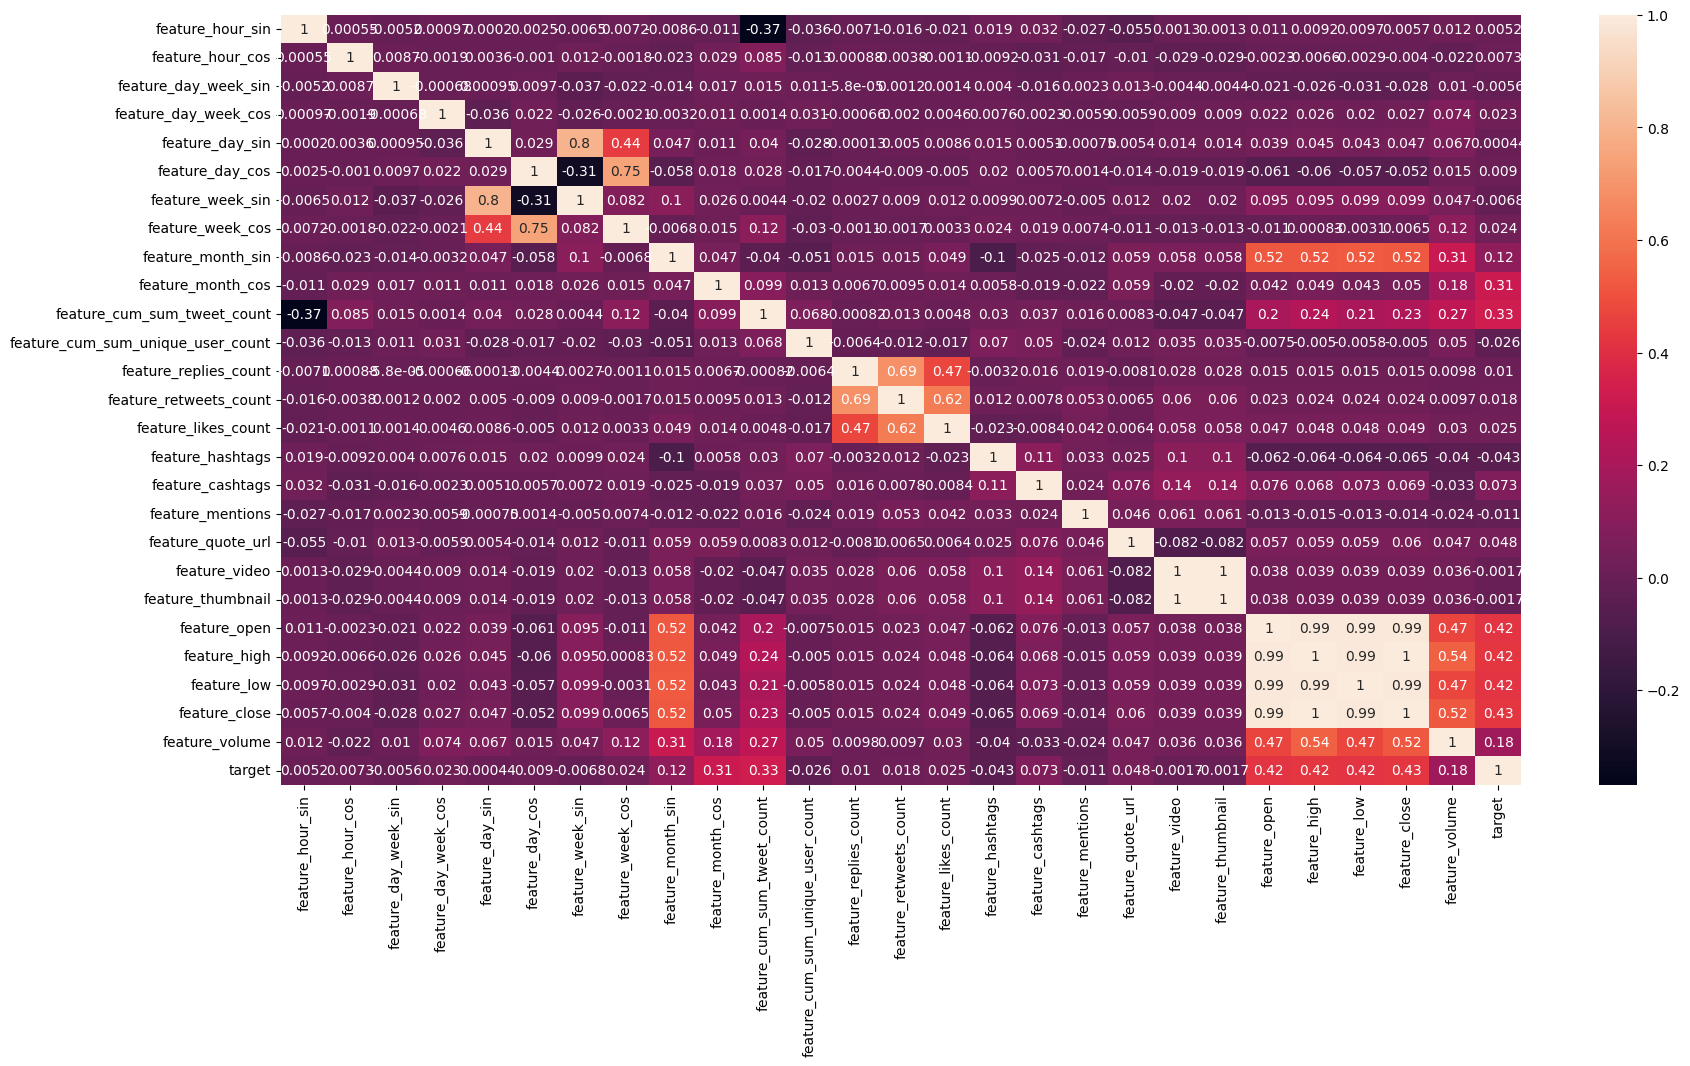

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix from your dataframe
corr = df_tabular.corr()

plt.figure(figsize=(20, 10))
# Create a heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)  # This will write the correlation values on the heatmap

plt.show()

### Text Data
Cleaning Tweets

In [21]:
NEG_CONTRACTIONS = {'ain':"ain't", 'aren':"are not", 'couldn':"could not",  'didn':"did not", 'doesn':"does not", 'hadn':"had not", 'hasn':"has not", 'haven':"have not", 'isn':"is not", 'mightn':"might not", 'mustn':"must not", 'needn':"need not", 'shan':"shall not", 'shouldn':"should not", 'wasn':"was not", 'weren':"were not", 'wouldn':"would not"}
ACRONYMS         = {'pls':'please', 'fsb':'federal security bureau', '₿itcoin':'bitcoin', 'mp':'member of parliament', 'bayc':'bored ape yacht club', 'usa':'united states of america', 'fca':'financial conduct authorithy', 'fcc':'federal communications commission', 'tvl':'total value locked', 'fdic':'federal deposit insurance corporation', 'doj':'departement of justice', 'ftc':'federal trade commission', 'cftc':'commodity futures trading commission', 'fomo':'fear of missing out', 'fud':'fear uncertainty doubt', 'kyc':'know your customer', 'hodlers':'holders', 'hodler':'holder', 'hodl':'hold', 'ito':'initial token offering', 'ico':'initial coin offering', 'dex':'decentralized exchange', 'ln':' lightning network', 'macd':'moving average convergence divergence', 'erc':'ethereum request for comments', 'eip':'ethereum improvement proposal', 'daos':'decentralized autonomous organization', 'dao':'decentralized autonomous organization', 'pow':'proof of work', 'ytd':'year to date', 'ath':'all time high', 'cpi':'consumer price index', 'ecb':'european central bank', 'fed':'federal reserve', 'lbma':'london bullion market association', 'fbi':'federal bureau of investigation', 'imf':'international monetary fund', 'ether':'ethereum', 'btcs':'bitcoins', 'eth':'ethereum', 'btc':'bitcoin', 'sec':'securities and exchange commission', 'ceo':'chief executive officer', 'etf':'exchange traded fund', 'uk':'united kingdom', 'defi':'decentralized finance', 'eu':'european union','nfts':'non fungible token', 'nft':'non fungible token', 'cbdcs':'central bank digital currency', 'cbdc':'central bank digital currency'}
UPPER_ACRONYMS   = {'USA':'united states of america', 'US':'united states', 'EU':'european union', 'U.S.':'united states', 'E.U.':'european union'}
STOPWORDS        = ['crypto', 'bitcoin', 'ethereum', 'non', 'fungible', 'token', 'in', 'gm', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'are', 'have', 'will', 'would', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'is', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'was', 'were', 'be', 'been', 'being', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'as', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'to', 'from', 'on', 'off', 'again', 'here', 'there', 'when', 'where', 'why', 'how', 'each', 'more', 'most', 'other', 'some', 'such', 'only', 'so', 'than', 'too', 's', 't', 'can', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'could', 'ma', 'might', 'must', 'need', 'shall', 'ü', 'ur', '4', '2', 'doin', 'ure', 'icymi', 'rt', 'ha']

lemma = WordNetLemmatizer()

In [22]:
df_text = pd.merge_asof(df_tweet, df_price, left_on="date", right_on="Date")
df_text["text"] = df_text["tweet"]
df_text["label"] = df_text["target"]
df_text[["text", "label"]]

,text,label
0,@oyepana2 @bakeobits Welcome to $OCEAN. Where...,0
1,$OCEAN here with 3RV Chart Pattern https://t....,0
2,There's a good chance that $INS is going to pu...,0
3,"@DaveCryptos $Sharering, $ocean, Blocktrade lol",0
4,@Pentoshiswallet Solid picks... I’d replace $x...,0
...,...,...
229852,"@cryptoworld202 $OCEAN, $LTC, $NGM and $DAFI a...",0
229853,"@CryptoGemsCom I have been buying $OCEAN, $BNB...",0
229854,"""The Energy Efficiency Data challenge is desig...",0
229855,Great! Let's go #datascientists💪 Do you have ...,0


In [23]:
def english_word_hastag(s):
    hashtag_words = re.findall(r"#(\w+)", s)
    result = map((lambda word: '#' + word), hashtag_words)
    result = sorted(result, key=len, reverse=True)
    if len(result) != 0:
        result = "|".join(result)
        hashtag_pattern = re.compile("("+result+")\S*")
        s = hashtag_pattern.sub(r'', s)
    return s

def remove_hashtag_series(text):
    index_to_remove = []

    words = text.split()
    hastag_words_index = []
    for i in range(len(words)):
        if '#' in words[i]:
            hastag_words_index.append(i)

    if len(hastag_words_index) > 1:
        for j in range(len(hastag_words_index)):
            if j == 0:
                continue
            if (hastag_words_index[j-1] + 1) == hastag_words_index[j]:
                index_to_remove.append(hastag_words_index[j-1])
            if (hastag_words_index[j-1]) == hastag_words_index[j] - 1:
                index_to_remove.append(hastag_words_index[j])
            if j == (len(hastag_words_index)-1) and (hastag_words_index[j-1] + 1) == hastag_words_index[j]:
                index_to_remove.append(hastag_words_index[j])

    index_to_remove = sorted(list(dict.fromkeys(index_to_remove)), reverse=True)
    for idx in index_to_remove:
        if idx < len(words):
            words.pop(idx)
    return " ".join(words)

def manage_contractions(s):
    tokens = s.split()
    tokens = [NEG_CONTRACTIONS[e] if e in NEG_CONTRACTIONS else e for e in tokens]
    tokens = [e.split() for e in tokens]
    tokens = [item for sublist in tokens for item in sublist]
    result = map((lambda x: contractions.fix(x)), tokens)
    return " ".join(result)

def manage_acronyms(s, acronyms):
    tokens = s.split()
    tokens = [acronyms[e] if e in acronyms else e for e in tokens]
    return " ".join(tokens)

def lemmatization_stopwords_management(text):
    text_tokens = word_tokenize(text)
    text_tokens = [word for word in text_tokens if not word in STOPWORDS]
    text_tokens = [lemma.lemmatize(word) for word in text_tokens]
    if len(text_tokens) > 0:
        last_word   = text_tokens[-1]
        if  last_word == 'read' or last_word == 'via':
            text_tokens = text_tokens[:-1]
    return (" ").join(text_tokens)

def remove_consecutive_words(text):
    text = ' '.join(k for k, _ in itertools.groupby(text.split()))
    return text

In [24]:
def clean_text(df):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
                                              
    df["clean_text"] = df['text'].str.replace(emoji_pattern, '', regex=True)
    df["clean_text"] = df.apply(lambda x: manage_acronyms(x.clean_text, UPPER_ACRONYMS), axis=1)
    df["clean_text"] = df["clean_text"].str.lower()
    df["clean_text"] = df['clean_text'].str.replace(r"(\S)(#)", r"\1 \2", regex=True) # add space between #
    df["clean_text"] = df['clean_text'].str.replace('(?:\$|\@|https?\://)\S+|www\.\S+', '', regex=True) # remove ticker $, @name, links
    df["clean_text"] = df['clean_text'].str.replace(r"(.)(\1{1})(\1+)", r"\1\2", regex=True) # remove repeated character : heeelloooo-> heelloo
    df["clean_text"] = df.apply(lambda x: remove_hashtag_series(x.clean_text), axis=1)
    df["clean_text"] = df.apply(lambda x: english_word_hastag(x.clean_text), axis=1)
    df["clean_text"] = df['clean_text'].str.replace('&\w+;', '', regex=True)
    df["clean_text"] = df['clean_text'].str.replace('\[.*?\]', '', regex=True)
    df["clean_text"] = df['clean_text'].str.replace('<.*?>+', '', regex=True)
    df["clean_text"] = df['clean_text'].str.replace("[-—'’']", ' ', regex=True)
    df["clean_text"] = df['clean_text'].str.replace('[%s]' % re.escape(string.punctuation), '', regex=True)
    df["clean_text"] = df['clean_text'].str.replace("[¡“’”►—🟧‘…•̇̇̇',․⏲​​⏰⁦––⏱‼⏫∞]", '', regex=True)
    df["clean_text"] = df['clean_text'].str.replace('\n', ' ', regex=True)
    df["clean_text"] = df['clean_text'].str.replace('\d', '', regex=True)
    df["clean_text"] = df.apply(lambda x: manage_contractions(x.clean_text), axis=1)
    df["clean_text"] = df.apply(lambda x: manage_acronyms(x.clean_text, ACRONYMS), axis=1)
    df["clean_text"] = df.apply(lambda x: lemmatization_stopwords_management(x.clean_text), axis=1)
    df["clean_text"] = df['clean_text'].str.replace(r"(^| ).(( ).)*( |$)", r' ', regex=True) # remove single character
    df["clean_text"] = df['clean_text'].str.strip()
    df["clean_text"] = df.apply(lambda x: remove_consecutive_words(x.clean_text), axis=1) # remove same consecutive words, buy buy buy -> buy
    df['split_clean_text'] = df['clean_text'].str.split()
    df = df[df['split_clean_text'].str.len() >= 4]
    return df

In [25]:
result = clean_text(df_text[["text", "label"]])

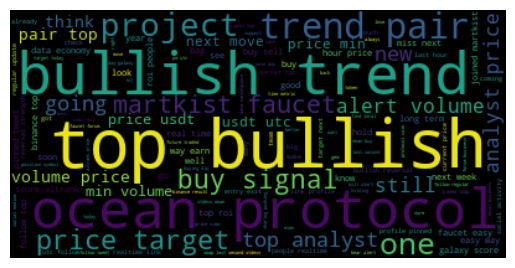

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_tmp_bearish = result[result['label'] == 0]
# Concatenate all the text in the column into a single string
text = ' '.join(df_tmp_bearish['clean_text'])

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Display the generated image using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

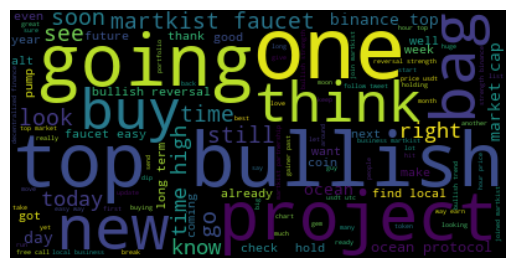

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_tmp_bullish = result[result['label'] == 2]
# Concatenate all the text in the column into a single string
text = ' '.join(df_tmp_bullish['clean_text'])

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Display the generated image using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

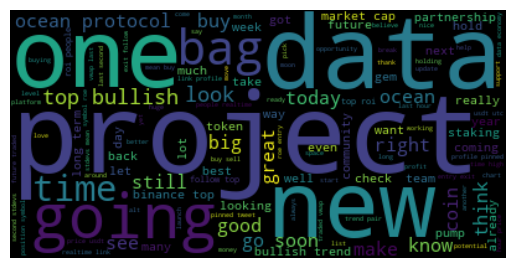

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_tmp_neutral = result[result['label'] == 1]
# Concatenate all the text in the column into a single string
text = ' '.join(df_tmp_neutral['clean_text'])

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Display the generated image using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Prepare Data for XGBoost and Transformer model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from collections import Counter

In [30]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(result['clean_text'], result['label'], 
                                                    stratify=result['label'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [31]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_text), y=y_train_text)
class_weights_dict = dict(enumerate(class_weights))

In [32]:
train_size = int(len(result) * 0.8)

X_train_text = result[['clean_text']][:train_size]
X_test_text  = result[['clean_text']][train_size:]

y_train_text = result[['label']][:train_size]
y_test_text  = result[['label']][train_size:]

In [33]:
X_train_tabular = df_tabular[[col for col in df_tabular if col.startswith('feature_')]]
X_train_tabular = X_train_tabular[X_train_tabular.index.isin(X_train_text.index.values)]
X_test_tabular  = df_tabular[[col for col in df_tabular if col.startswith('feature_')]]
X_test_tabular  = X_test_tabular[X_test_tabular.index.isin(X_test_text.index.values)]

y_train_tabular = df_tabular[['target']]
y_train_tabular = y_train_tabular[y_train_tabular.index.isin(y_train_text.index.values)]
y_test_tabular  = df_tabular[['target']]
y_test_tabular  = y_test_tabular[y_test_tabular.index.isin(y_test_text.index.values)]


## XGBoost training

In [34]:
from xgboost import XGBClassifier

def init_xgb_model():
    params = {
        "colsample_bytree":0.3,
        "max_depth":4,
        "learning_rate":0.025,
        "n_estimators":2250,# 2250,
        "subsample":0.75,
        "reg_lambda":0.05, # L2 Regularization
        "reg_alpha":0,
        "objective":"multi:softprob",
        "eval_metric":"auc",
        "early_stopping_rounds":100
    }
    model = XGBClassifier(**params)
    return model

def train_xgb_model(model, X_train, y_train):
    model.fit(X_train, y_train,
          eval_set=[(X_train, y_train)], verbose=500)
    return model

model = init_xgb_model()
model = train_xgb_model(model, X_train_tabular.values, y_train_tabular['target'].values)

[0]	validation_0-auc:0.92253
[500]	validation_0-auc:0.99990
[1000]	validation_0-auc:1.00000
[1500]	validation_0-auc:1.00000
[1839]	validation_0-auc:1.00000


### Evaluation XGBoost

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_pred = model.predict(X_test_tabular.values)
y_pred_proba = model.predict_proba(X_test_tabular.values)

df_y_proba = pd.DataFrame(y_pred_proba, columns=["Bearish", "Neutral", "Bullish"])

In [36]:
acc = accuracy_score(y_test_tabular['target'].values, y_pred)
f1_score = f1_score(y_test_tabular['target'].values, y_pred, average='weighted')
acc, f1_score

(0.39144510938879623, 0.5341803085518796)

# Inference

In [37]:
tweet =  'chart look good overall moving strongly weakness positive sign running resistance both pair position lower take profit case bounce back down not good entry say'

In [38]:
tab_pred = model.predict_proba(np.array([X_test_tabular.values[-6522]]))

In [39]:
from transformers import pipeline

In [40]:
classifier = pipeline(model="lucaordronneau/distilbert-base-uncased-finetuned-OCEAN-sentiment")
text_pred = classifier(
   tweet
)
text_pred

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.0 with CUDA None (you have 2.1.0.dev20230614)
    Python  3.9.13 (you have 3.9.13)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


[{'label': 'Bearish', 'score': 0.9958354234695435}]

In [41]:
np.amax(tab_pred) + int(text_pred[0]['score'])

0.9560317397117615

## Save for Training

In [42]:
train = pd.concat([X_train_text, y_train_text], axis=1)
train["text"] = train["clean_text"]
train = train[["text", "label"]]

test = pd.concat([X_test_text, y_test_text], axis=1)
test["text"] = test["clean_text"]
test = test[["text", "label"]]

In [43]:
train.to_csv('../data/train.csv', index=False)
test.to_csv('../data/test.csv', index=False)

In [44]:
X_train_text.to_csv('../data/X_train_text.csv', index=False)
X_test_text.to_csv('../data/X_test_text.csv', index=False)

y_train_text.to_csv('../data/y_train_text.csv', index=False)
y_test_text.to_csv('../data/y_test_text.csv', index=False)

X_train_tabular.to_csv('../data/X_train_tabular.csv', index=False)
X_test_tabular.to_csv('../data/X_test_tabular.csv', index=False)

y_train_tabular.to_csv('../data/y_train_tabular.csv', index=False)
y_test_tabular.to_csv('../data/y_test_tabular.csv', index=False)